In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Input, Embedding, Lambda, Dense, concatenate, Flatten
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
import lightgbm as lgb

import datetime
from time import time
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['home-depot-product-search-relevance', 'gnewsvector']


# Read the data

In [6]:
train = pd.read_csv('../input/home-depot-product-search-relevance/train.csv', encoding="ISO-8859-1")
test = pd.read_csv('../input/home-depot-product-search-relevance/test.csv', encoding="ISO-8859-1")
# prod = pd.read_csv('../input/home-depot-product-search-relevance/product_descriptions.csv')

print('train size', train.shape)
print('test size', test.shape)
# print('prod size', prod.shape)

train size (74067, 5)
test size (166693, 4)


In [7]:
train_size = train.shape[0]
df_all = pd.concat((train, test), axis=0, ignore_index=True)
# df_all = pd.merge(df_all, prod, on='product_uid', how='left')
# df_all['product_title'] = (df_all['product_title'] + df_all['product_description'])
# df_all.drop(['product_description', 'product_uid', 'id'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [8]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


# Split product_full_info and search_term to chars

In [9]:
char_to_remove = [' ', '{', '}', '"', '(', ')', '.', ',', '&','[',']','`','_','\'', '~', '\\', '-' 
                  '\x80', '\x81', '\x84', '\x89', '\x8b', '\x90', '\x93', '\x95', '\x99', '\x9a', 
                  '\x9d', '\xa0', '¡', '¢', 'ª', 'À', 'Â', 'È', 'Ê', 'Ë', 'Ï', 'Ò', 'Û', 
                  'Ü', 'â', 'ã', 'å', 'è', '÷']

def lower_char(char):
    if char >= 'A' and char <= 'Z':
        return char.lower()
    else:
        return char

df_all['product_title'] = df_all['product_title'].apply(lambda sent: [lower_char(character) for character in sent if character not in char_to_remove])
df_all['search_term'] = df_all['search_term'].apply(lambda sent: [lower_char(character) for character in sent if character not in char_to_remove])

# df_all['product_title'] = df_all['product_title'].apply(lambda x: x[:400])

In [10]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,"[s, i, m, p, s, o, n, s, t, r, o, n, g, -, t, ...",100001,3.00,"[a, n, g, l, e, b, r, a, c, k, e, t]"
1,3,"[s, i, m, p, s, o, n, s, t, r, o, n, g, -, t, ...",100001,2.50,"[l, b, r, a, c, k, e, t]"
2,9,"[b, e, h, r, p, r, e, m, i, u, m, t, e, x, t, ...",100002,3.00,"[d, e, c, k, o, v, e, r]"
3,16,"[d, e, l, t, a, v, e, r, o, 1, -, h, a, n, d, ...",100005,2.33,"[r, a, i, n, s, h, o, w, e, r, h, e, a, d]"
4,17,"[d, e, l, t, a, v, e, r, o, 1, -, h, a, n, d, ...",100005,2.67,"[s, h, o, w, e, r, o, n, l, y, f, a, u, c, e, t]"


# Get all unique chars to preform lable encoder

In [11]:
prod_all_sentences = df_all['product_title']
search_all_sentences = df_all['search_term']

all_unique_chars = np.unique(np.concatenate((prod_all_sentences.append(search_all_sentences).values), axis=None))
all_unique_chars = np.append(['<uniq>'], all_unique_chars)

In [12]:
all_unique_chars

array(['<uniq>', '!', '#', '$', '%', '*', '+', '-', '/', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'a', 'b',
       'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
       'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x80', '°',
       '²'], dtype='<U6')

# Replace tokens in numbers using lable encoder

In [13]:
le = LabelEncoder()
def token_to_num(data, unique_valus):
    le.fit(unique_valus)
    data['product_title'] = data['product_title'].apply(lambda char_list: le.transform(char_list).astype(float)) 
    data['search_term'] = data['search_term'].apply(lambda char_list: le.transform(char_list).astype(float)) 
    return data

df_all = token_to_num(df_all, all_unique_chars)

In [14]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,"[41.0, 31.0, 35.0, 38.0, 41.0, 37.0, 36.0, 41....",100001,3.00,"[23.0, 36.0, 29.0, 34.0, 27.0, 24.0, 40.0, 23...."
1,3,"[41.0, 31.0, 35.0, 38.0, 41.0, 37.0, 36.0, 41....",100001,2.50,"[34.0, 24.0, 40.0, 23.0, 25.0, 33.0, 27.0, 42.0]"
2,9,"[24.0, 27.0, 30.0, 40.0, 38.0, 40.0, 27.0, 35....",100002,3.00,"[26.0, 27.0, 25.0, 33.0, 37.0, 44.0, 27.0, 40.0]"
3,16,"[26.0, 27.0, 34.0, 42.0, 23.0, 44.0, 27.0, 40....",100005,2.33,"[40.0, 23.0, 31.0, 36.0, 41.0, 30.0, 37.0, 45...."
4,17,"[26.0, 27.0, 34.0, 42.0, 23.0, 44.0, 27.0, 40....",100005,2.67,"[41.0, 30.0, 37.0, 45.0, 27.0, 40.0, 37.0, 36...."


# Check max product description and search term length to know how much padding needed

In [15]:
def get_max_length(data):
    max_len = 0
    for i in range(0, len(data)):
        if len(data.iloc[i]) > max_len:
            max_len = len(data.iloc[i])
    return max_len

def get_avg_length(data):
    len_sum = 0
    for i in range(0, len(data)):
        len_sum += len(data.iloc[i])
    return int(len_sum / len(data))

# avg_length_prod = get_avg_length(df_all['product_title'])
# avg_length_search = get_avg_length(df_all['search_term'])

max_length_prod = get_max_length(df_all['product_title'])
max_length_search = get_max_length(df_all['search_term'])

In [16]:
# print('avg_length_prod', avg_length_prod)
# print('avg_length_search', avg_length_search)

print('max_length_prod', max_length_prod)
print('max_length_search', max_length_search)

max_length_prod 128
max_length_search 58


# Split back to train and test sets

In [17]:
df_train = df_all.iloc[:train_size]
df_test = df_all.iloc[train_size:]
df_test.reset_index(inplace=True, drop=True)

y_data = df_train['relevance']

# transform relevance to labels

In [18]:
le_labels = LabelEncoder()
le_labels.fit(y_data.unique())
y_data_labels = le_labels.transform(y_data)

# Split to two sides:
1. search_term
2. product_desctiption + title

In [19]:
X_data = {'left': df_train['product_title'], 'right': df_train['search_term']}
X_test = {'left': df_test['product_title'], 'right': df_test['search_term']}

# Add zero padding to each char list in size of max_length

In [20]:
for dataset in [X_data, X_test]:
    dataset['left'] = pad_sequences(dataset['left'], maxlen=max_length_prod)
    dataset['right'] = pad_sequences(dataset['right'], maxlen=max_length_search)

In [21]:
def reshpe_data(data):
    data['left'] = np.reshape(data['left'], (data['left'].shape[0], data['left'].shape[1], 1))
    data['right'] = np.reshape(data['right'], (data['right'].shape[0], data['right'].shape[1], 1))  
    return data

X_data = reshpe_data(X_data)
X_test = reshpe_data(X_test)

In [22]:
print('X_train left shape', X_data['left'].shape)
print('X_train right shape', X_data['right'].shape)
print('y_train shape', y_data.shape)

print('X_test left shape', X_test['left'].shape)
print('X_test right shape', X_test['right'].shape)

X_train left shape (74067, 128, 1)
X_train right shape (74067, 58, 1)
y_train shape (74067,)
X_test left shape (166693, 128, 1)
X_test right shape (166693, 58, 1)


# Build the model

In [23]:
def get_model():

    # input layer
    left_input = Input(shape=(max_length_prod, 1))
    right_input = Input(shape=(max_length_search, 1))

    # LSTM layer
    shared_lstm = LSTM(n_lstm_hidden)
    left_output = shared_lstm(left_input)
    right_output = shared_lstm(right_input)

    # concat two outputs
    concat = concatenate([left_output, right_output])

    # add Dense layer to calculate the similarty between product title and search term
    output = Dense(1)(concat)

    # Pack it all up into a model
    siamese_model = Model([left_input, right_input], output)

    # colmpiling
    siamese_model.compile(loss='mse', optimizer='adam')
    return siamese_model

In [24]:
def split_to_train_val(data_x, data_y, train_index, val_index):
    train_left = data_x['left'][train_index]
    train_right = data_x['right'][train_index]
    y_train = data_y[train_index]  
    val_left = data_x['left'][val_index]
    val_right = data_x['right'][val_index]
    y_val = data_y[val_index]
    
    return train_left, train_right, val_left, val_right, y_train, y_val

In [25]:
# Plot loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train on 59251 samples, validate on 14816 samples
Epoch 1/5
59251/59251 [==============================] - 31s 518us/step - loss: 0.5191 - val_loss: 0.2816
Epoch 2/5
59251/59251 [==============================] - 28s 464us/step - loss: 0.2802 - val_loss: 0.2794
Epoch 3/5
59251/59251 [==============================] - 28s 464us/step - loss: 0.2793 - val_loss: 0.2790
Epoch 4/5
59251/59251 [==============================] - 28s 475us/step - loss: 0.2791 - val_loss: 0.2783
Epoch 5/5
59251/59251 [==============================] - 28s 466us/step - loss: 0.2785 - val_loss: 0.2781
rmse 0.5273972972161032


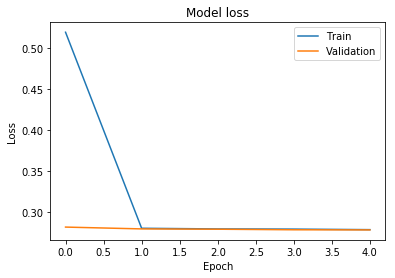

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 29s 490us/step - loss: 0.9900 - val_loss: 0.2839
Epoch 2/5
59253/59253 [==============================] - 28s 465us/step - loss: 0.2836 - val_loss: 0.2820
Epoch 3/5
59253/59253 [==============================] - 28s 465us/step - loss: 0.2810 - val_loss: 0.2788
Epoch 4/5
59253/59253 [==============================] - 28s 466us/step - loss: 0.2801 - val_loss: 0.2784
Epoch 5/5
59253/59253 [==============================] - 28s 465us/step - loss: 0.2794 - val_loss: 0.2775
rmse 0.526828977621957


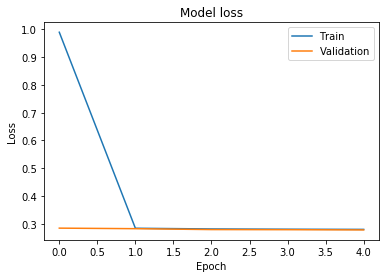

Train on 59254 samples, validate on 14813 samples
Epoch 1/5
59254/59254 [==============================] - 29s 495us/step - loss: 0.8383 - val_loss: 0.2820
Epoch 2/5
59254/59254 [==============================] - 27s 463us/step - loss: 0.2797 - val_loss: 0.2816
Epoch 3/5
59254/59254 [==============================] - 28s 464us/step - loss: 0.2792 - val_loss: 0.2816
Epoch 4/5
59254/59254 [==============================] - 27s 463us/step - loss: 0.2787 - val_loss: 0.2811
Epoch 5/5
40704/59254 [===================>..........] - ETA: 8s - loss: 0.2781

KeyboardInterrupt: 

In [26]:
# Model variables
n_lstm_hidden = 25
batch_size = 256
n_epoch = 5

pred_test = np.zeros(X_test['left'].shape[0])
mean_rmse = 0

n_splits = 5
# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=24)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

for train_index, test_index in kfold.split(X_data['left'], y_data_labels):    
    X_train_left_kfold, X_train_right_kfold, X_val_left_kfold, X_val_right_kfold, y_train_kfold, y_val_kfold = split_to_train_val(X_data, y_data.values, train_index, test_index)
    
    siamese_model = get_model()
    history = siamese_model.fit([X_train_left_kfold, X_train_right_kfold], y_train_kfold,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val_left_kfold, X_val_right_kfold], y_val_kfold))
    
    pred_val = siamese_model.predict([X_val_left_kfold, X_val_right_kfold])
    rmse = sqrt(mean_squared_error(y_val_kfold, pred_val))
    mean_rmse += (rmse / n_splits)
    
    pred_test += np.reshape((siamese_model.predict([X_test['left'], X_test['right']]) / n_splits), (len(pred_test),))    
    
    print('rmse', rmse)
    plot_loss(history)
    
print('mean rmse', mean_rmse)

# Use the model we got as feature extractor 
1. for XGBoost model
2. for lightgbm model

In [ ]:
# Train the model on all the data
siamese_model = get_model()
history = siamese_model.fit([X_data['left'], X_data['right']], y_data.values, batch_size=batch_size, epochs=n_epoch)

# get the output of the concat layer and use it as features to the ml models
concat_layer = siamese_model.layers[3].output
feature_model = Model(siamese_model.input, concat_layer)
feature_model.compile(loss='mse', optimizer='adam')
print(feature_model.summary())

# we use the output of the concat layer as fetures so they will be the input to the xgb and lgb models
featurs = feature_model.predict([X_data['left'], X_data['right']])

# we preform the prediction also on the test set to evaluate the mse on test set
features_test = feature_model.predict([X_test['left'], X_test['right']])

In [ ]:
# # get the output of the concat layer and use it as features to the ml models
# concat_layer = siamese_model.layers[3].output
# feature_model = Model(siamese_model.input, concat_layer)
# feature_model.compile(loss='mse', optimizer='adam')
# print(feature_model.summary())

# # we use the output of the concat layer as fetures so they will be the input to the xgb and lgb models
# featurs = feature_model.predict([X_train_left_kfold, X_train_right_kfold])

# # we preform the prediction also on the test set to evaluate the mse on test set
# features_test = feature_model.predict([X_val_left_kfold, X_val_right_kfold])

In [ ]:
# xgb
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.8, colsample_bytree=1, max_depth=7)
xgb_model.fit(featurs, y_data)
xgb_pred = xgb_model.predict(features_test)

# lgb
lgb_model = lgb.sklearn.LGBMRegressor(is_unbalance=True, learning_rate =0.01, subsample=0.8, colsample_bytree=0.6, max_depth=7)
lgb_model.fit(featurs, y_data)
lgb_pred = lgb_model.predict(features_test)


# xgb_rmse = np.sqrt(mean_squared_error(y_val_kfold, xgb_pred))
# lgb_rmse = np.sqrt(mean_squared_error(y_val_kfold, lgb_pred))

In [ ]:
def round_pred(pred):
    for i in range(0,len(pred)):
        if pred[i] < 1:
            pred[i] = 1
        if pred[i] > 3:
            pred[i] = 3
    return pred

xgb_pred = round_pred(xgb_pred.astype(float))
lgb_pred = round_pred(lgb_predastype(float))

In [ ]:
# print(xgb_rmse, lgb_rmse)

# Write predictions to sample submission file

In [ ]:
sample_sub = pd.DataFrame()
sample_sub['id'] = test['id']
sample_sub['relevance'] = pred_test
sample_sub.to_csv('sample_submmision_char_siamese.csv', index=False)

sample_sub['relevance'] = xgb_pred
sample_sub.to_csv('sample_submmision_char_xgb.csv', index=False)

sample_sub['relevance'] = lgb_pred
sample_sub.to_csv('sample_submmision_char_lgb.csv', index=False)

# Word embedding

In [46]:
embed_size = 300
max_features = 50000 

# Tokenize the sentences
tokenizer = Tokenizer(num_words=100000, filters='!"$&()*+,-.:;<=>?[\]^_`{|}~')
tokenizer.fit_on_texts(list(train['product_title'].values))
X_train = tokenizer.texts_to_sequences(train['product_title'].values)
# X_val = tokenizer.texts_to_sequences(X_val)
# X_test = tokenizer.texts_to_sequences(X_test)


In [47]:
X_train = pad_sequences(X_train, maxlen=max_length_prod)

In [58]:
EMBEDDING_FILE = '../input/gnewsvector/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
embedding_matrix[0] = 0
for word, i in word_index.items():
    if i >= max_features: 
        continue
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index.get_vector(word)

del EMBEDDING_FILE
gc.collect()

581

In [ ]:
# Model variables
n_lstm_hidden = 25
batch_size = 256
n_epoch = 5

pred_test = np.zeros(X_test['left'].shape[0])
mean_rmse = 0

n_splits = 5
# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=24)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

for train_index, test_index in kfold.split(X_data['left'], y_data_labels):    
    X_train_left_kfold, X_train_right_kfold, X_val_left_kfold, X_val_right_kfold, y_train_kfold, y_val_kfold = split_to_train_val(X_data, y_data.values, train_index, test_index)
    
    siamese_model = get_model()
    history = siamese_model.fit([X_train_left_kfold, X_train_right_kfold], y_train_kfold,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val_left_kfold, X_val_right_kfold], y_val_kfold))
    
    pred_val = siamese_model.predict([X_val_left_kfold, X_val_right_kfold])
    rmse = sqrt(mean_squared_error(y_val_kfold, pred_val))
    mean_rmse += (rmse / n_splits)
    
    pred_test += np.reshape((siamese_model.predict([X_test['left'], X_test['right']]) / n_splits), (len(pred_test),))    
    
    print('rmse', rmse)
    plot_loss(history)
    
print('mean rmse', mean_rmse)